### Wykrywanie obszarów ruchu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray


path = './'

im1 = io.imread(path + 'ziarna1.jpg')
im2 = io.imread(path + 'ziarna2.jpg')


plt.imshow(im1)
plt.show()

plt.imshow(im2)
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

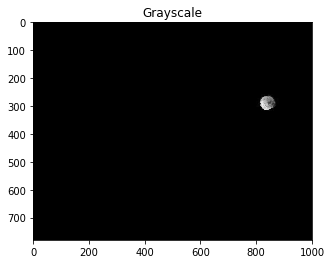

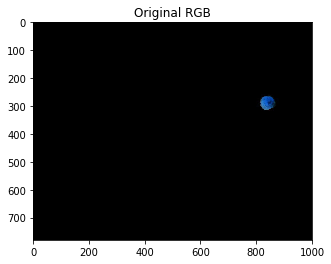

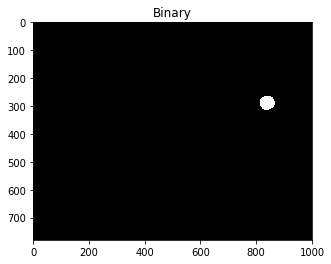

In [2]:
import cv2

diff = cv2.absdiff(im1, im2)

gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)

plt.imshow(gray, cmap="gray")
plt.title('Grayscale')
plt.show()

ret, diff2 = cv2.threshold(gray,20,255,cv2.THRESH_BINARY)

plt.imshow(diff)
plt.title('Original RGB')
plt.show()

plt.imshow(diff2, cmap="gray")
plt.title('Binary')
plt.show()

Status: object detected
813 264 54 51


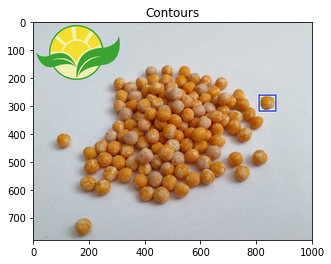

(780, 1000, 3)


In [3]:
import numpy as np

kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(diff2, cv2.MORPH_CLOSE, kernel)

cnts = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[1]
# cnts = imutils.grab_contours(cnts)

minArea = 50
margin = 3

for c in cnts:
    if cv2.contourArea(c) > minArea:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(im2, (x - margin, y - margin), (x + w + margin, y + h + margin), (0, 0, 255), 2)
        print('Status: object detected')
        print(x, y, w, h)

        plt.imshow(im2, interpolation='lanczos')
        plt.title('Contours')
        plt.show()
        
        print(im2.shape)
        

### Wykrywanie obszarów ruchu
#### Analiza poklatkowa na przykładzie strumienia wideo
####    

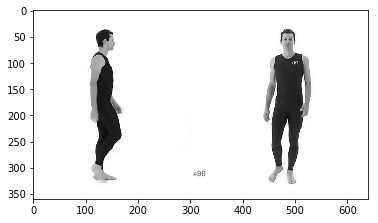

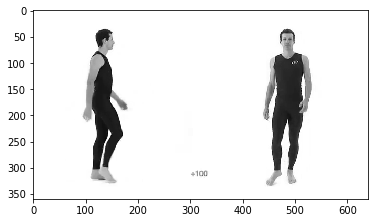

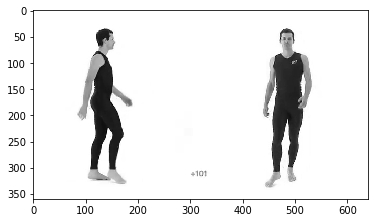

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture('./man-walk.mp4')

counter = 1
fnum = [100, 101, 102]
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret == False:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    if counter in fnum:
        plt.imshow(gray, cmap='gray')
        plt.show()

    counter += 1
        
cap.release()

In [5]:
# from imutils.video import VideoStream
# import imutils
import numpy as np

def motionDetect(frame, num):

    bg = 255*np.ones_like(frame)
    
    diff = cv2.absdiff(frame, bg)

    gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)

    ret, diff2 = cv2.threshold(gray,20,255,cv2.THRESH_BINARY)
    
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(diff2, cv2.MORPH_CLOSE, kernel)

    cnts = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[1]

    minArea = 500
    margin = 3

    for c in cnts:
        if cv2.contourArea(c) > minArea:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(frame, (x - margin, y - margin), (x + w + margin, y + h + margin), (0, 0, 255), 2)
            print('Frame no.: ' + str(num))
            print('Status: object detected')
            print('Motion area: ', x, y, w, h, end="\n\n")

    plt.figure()
    plt.imshow(frame, interpolation='lanczos')
    plt.title('Contours')
    plt.show()

Frame no.: 100
Status: object detected
Motion area:  440 36 92 296

Frame no.: 100
Status: object detected
Motion area:  107 36 64 294



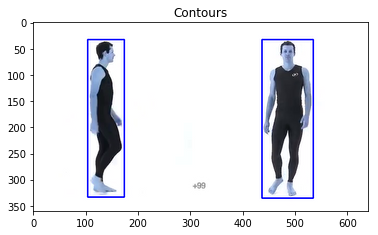

Frame no.: 101
Status: object detected
Motion area:  440 35 93 301

Frame no.: 101
Status: object detected
Motion area:  94 35 88 296



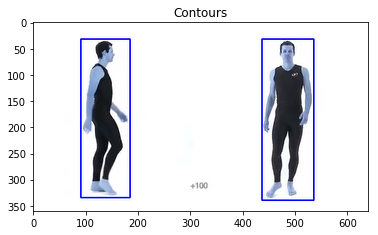

Frame no.: 102
Status: object detected
Motion area:  439 35 94 304

Frame no.: 102
Status: object detected
Motion area:  85 35 106 296



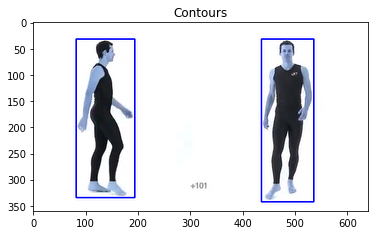

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture('./man-walk.mp4')

counter = 1
fnum = list(range(100,103))

prevFrame = None

while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret == False:
        break

    if counter in fnum:
        motionDetect(frame, counter)

    counter += 1
        
cap.release()

### Metoda uśredniania tła :: wyznaczanie modelu tła

<ol>
<li style="margin: 3px">Obliczamy średni obraz tła</li>
<li style="margin: 3px">Obliczamy odchylenie standardowe tła (przybliżenie: średnie różnice, FFAAD)</li>
    + FFAAD (ang. Frame-to-Frame Average Absolute Difference)
<li style="margin: 3px">Ustalamy progi względem wielokrotności FFAAD:</li>
    + HighThreshold
    + LowThreshold
<li style="margin: 3px">Odejmujemy poszczególne klatki obrazu i porównujemy z modelem tła</li>    
<li style="margin: 3px">Piksele nie pasujące do modelu tła uznajemy za obszar obiektów w ruchu</li>    
</ol>